# Configuration

In [1]:
# directory to store intermediate and final results of the experiment
EXPERIMENT_DIR                 = "/home/schindlera/experiments/ismir2020_reviews/"

METADATA_PATH                  = EXPERIMENT_DIR + "/experiment_partition.h5"

# Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np

import progressbar as pb

from gensim import corpora, models, similarities

# Load and Process Metadata

In [3]:
# Load Metadata
metadata_final         = pd.read_hdf(METADATA_PATH, "data")

In [4]:
metadata_train = metadata_final[metadata_final.train]
metadata_test  = metadata_final[metadata_final.test ]
metadata_val   = metadata_final[metadata_final.val  ]

In [5]:
metadata_train.shape[0], metadata_test.shape[0], metadata_val.shape[0]

(247480, 254636, 2500)

# Functions

In [6]:
def merge_and_sort_tags(row):
    
    merged_tags = []
    
    for col in row.index:
        
        is_nan = pd.isnull(row[col])
        
        if type(is_nan) != bool:
            is_nan = is_nan.all()
        
        if not is_nan:
            merged_tags.extend(row[col])
            
    return sorted(merged_tags)

In [7]:
def sparse_to_dense(vec):

    dense_vec = np.zeros(NUM_LSI_TOPICS)

    for v in vec:
        dense_vec[v[0]] = v[1]

    return dense_vec

In [8]:
def calc_topic_vectors(joined_tags, dictionary, topic_model):

    topic_vectors = []

    for tid in pb.ProgressBar()(joined_tags.index):

        query_doc       = joined_tags.loc[tid]

        vec_bow         = dictionary.doc2bow(query_doc)
        vec_topic_model = topic_model[vec_bow]
        vec_topic_model = sparse_to_dense(vec_topic_model)
        topic_vectors.append(vec_topic_model)


    return np.stack(topic_vectors, axis=0), joined_tags.index

# Topic Modelling

## Latent Semantic Indexing

### Derive Topic Model from Tagset

Configuration

In [9]:
NUM_LSI_TOPICS = 340
TAG_SET        = ["styles", "moods", "themes", "genres"]

Join Tags from configured Tag-Sets

In [10]:
md_joined_tags_train = metadata_train[TAG_SET].apply(lambda x: merge_and_sort_tags(x), axis=1)

Derive LSI Topic Model

In [11]:
tag_dictionary    = corpora.Dictionary(md_joined_tags_train)

tag_corpus        = [tag_dictionary.doc2bow(doc) for doc in md_joined_tags_train]

tag_tfidf         = models.TfidfModel(tag_corpus)
tag_corpus_tfidf  = tag_tfidf[tag_corpus]

tag_lsi           = models.LsiModel(tag_corpus_tfidf, id2word=tag_dictionary, num_topics=NUM_LSI_TOPICS)

Embedd all Tags for all Tracks in Topic-Model

In [12]:
md_joined_tags_all = metadata_final[TAG_SET].apply(lambda x: merge_and_sort_tags(x), axis=1)

In [13]:
lsi_vectors, lsi_track_ids = calc_topic_vectors(md_joined_tags_all, tag_dictionary, tag_lsi)

100% (504616 of 504616) |################| Elapsed Time: 0:04:27 Time:  0:04:27


In [14]:
pd_lsi_vectors = pd.DataFrame(lsi_vectors, index=lsi_track_ids)

### Store Topic Embeddings

In [15]:
for par in ["train", "val", "test"]:
    
    # path to partition file
    par_file = "%s/eval_partition_trackids_%s.csv" % (EXPERIMENT_DIR, par)
    
    # load partition
    par_trackids = pd.read_csv(par_file, header=None, index_col=0)

    # slice topic vectors and align with partition file (should be in synch with audio features)
    par_lsi_vectors = pd_lsi_vectors.loc[par_trackids.index]

    # save embeddings for this partition
    np.savez(file     = "%s/rel_content_emb_tag_lsi_%s.npz" % (EXPERIMENT_DIR, par), 
             data     = par_lsi_vectors.values.astype(np.float32), 
             trackids = par_lsi_vectors.index)

# Evaluate

In [18]:
from scipy.spatial.distance import cdist

In [128]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
par_file = f'{EXPERIMENT_DIR}/eval_partition_trackids_train.csv'

# load partition
train_trackids = pd.read_csv(par_file, header=None, index_col=0)

train_lsi_vectors = pd_lsi_vectors.loc[train_trackids.index]

In [127]:
sample_idx = np.random.choice(np.arange(train_lsi_vectors.shape[0]), 1000)

train_lsi_vectors_sample = train_lsi_vectors.iloc[sample_idx]

pairwise_cosine_sims = cdist(train_lsi_vectors_sample, train_lsi_vectors_sample, metric="cosine")

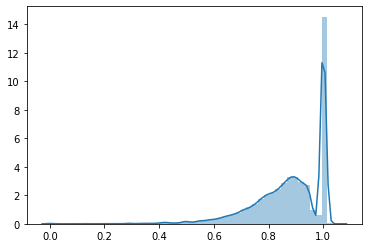

In [130]:
sns.distplot(pairwise_cosine_sims[np.triu_indices(pairwise_cosine_sims.shape[0],1)], rug=False);

In [131]:
hists = []

for i in range(1000):
    h,_ = np.histogram(pairwise_cosine_sims[i,:], bins=np.arange(0.0,1.1,0.01))
    hists.append(h)

hists = np.asarray(hists)

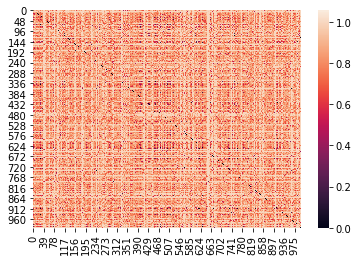

In [136]:
sns.heatmap(pairwise_cosine_sims);

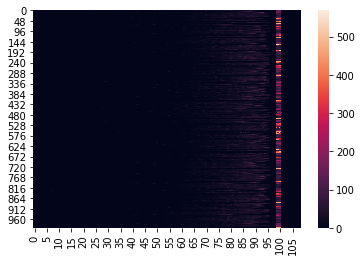

In [134]:
sns.heatmap(hists);

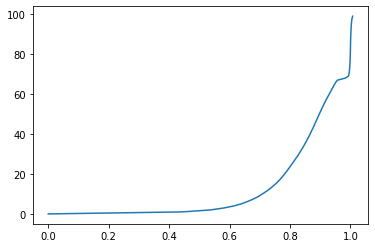

In [163]:
sns.lineplot([np.percentile(pairwise_cosine_sims, i) for i in range(100)], np.arange(100));

In [156]:
import scipy

In [164]:
percentiles = []

for i in range(1000):
    percentiles.append([np.percentile(pairwise_cosine_sims[i,:], j) for j in range(100)])
    
percentiles = np.asarray(percentiles)

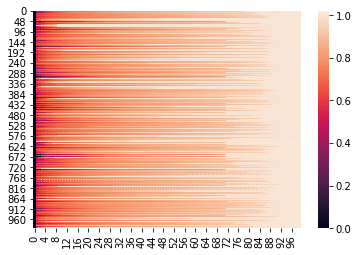

In [165]:
sns.heatmap(percentiles);

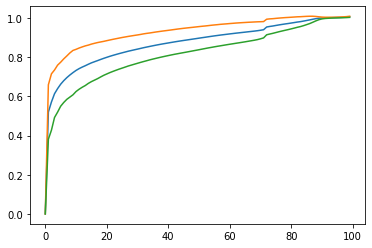

In [182]:
sns.lineplot(np.arange(100), percentiles.mean(axis=0));
sns.lineplot(np.arange(100), percentiles.mean(axis=0) + percentiles.std(axis=0));
sns.lineplot(np.arange(100), percentiles.mean(axis=0) - percentiles.std(axis=0));

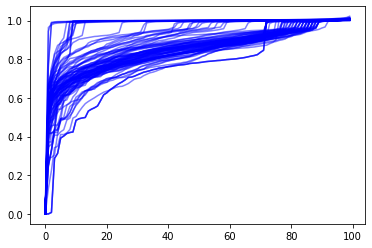

In [183]:
for i in range(100):
    sns.lineplot(np.arange(100), percentiles[i,:], color='b', alpha=0.5);

In [166]:
from mpl_toolkits.mplot3d import Axes3D

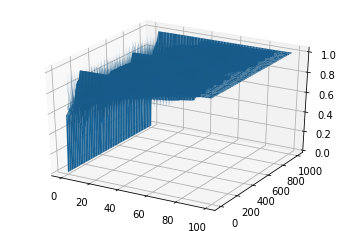

In [177]:
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

X, Y = np.meshgrid(range(100), range(1000))  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X, Y, percentiles)

In [169]:
percentiles.shape

(1000, 100)

In [188]:
scipy.stats.percentileofscore(pairwise_cosine_sims.flatten(), 0.99, kind='rank')

68.3312

In [196]:
scipy.stats.percentileofscore(pairwise_cosine_sims[np.triu_indices(pairwise_cosine_sims.shape[0],1)].flatten(), 
                              0.99, kind='mean')

68.29949949949949

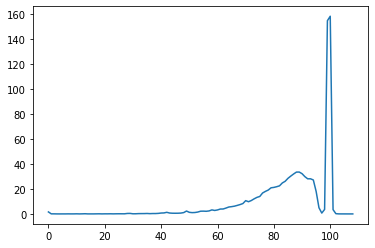

In [143]:
sns.lineplot(np.arange(109), hists.mean(axis=0));

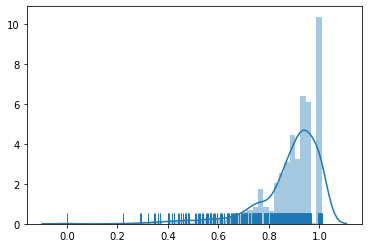

In [133]:
sns.distplot(pairwise_cosine_sims[3,:], rug=True);